# Introduction
We are using the "Melanoma Detection Dataset" from Kaggle ([Source](https://www.kaggle.com/datasets/wanderdust/skin-lesion-analysis-toward-melanoma-detection). The dataset contains labeled images of different skin lesions: melanoma, nevus and seborrheic keratosis. The goal of the dataset and this implementation with different ML techniques is, to support an automated diagnosis of melanoma. 

In [1]:
# Library import ----

library(keras)
library(tensorflow)
tf$version$VERSION  #2.6.5
library(tidyverse)
require(graphics)
library(randomForest)
library(grid)

Loaded Tensorflow version 2.6.5



[1] "2.6.5"

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin




In [2]:
# Define utility functions ----
load_data <- function(base_path, type = 'train', image_size=64) { 
  
  path <- fs::path(base_path, type)
  img_ls<- fs::dir_ls(path, recurse = TRUE, type='file') 
  
  y_type <- rep('default', length(img_ls))
  X_type = array(dim=c(length(img_ls), image_size, image_size ,3L))
  
  loaded = 0
  for (idx in 1:length(img_ls)) {
    
    img_path <- img_ls[idx]
    type_folder <- stringr::str_extract(img_path, pattern="(melanoma|nevus|seborrheic_keratosis).ISIC_[0-9]{0,20}.jpg")
    type <- stringr::str_extract(type_folder, pattern="(melanoma|nevus|seborrheic_keratosis)")
    img <- keras::image_load(img_path, target_size = c(image_size,image_size))
    img.arr <- keras::image_to_array(img)
    X_type[idx,,,] = img.arr
    y_type[idx] <- type
    
    # Dummy code output 
    loaded = loaded + 1
    
  }
  print(paste0('Loaded:', path))
  return (list(X=X_type, y_label=as.factor(y_type), y_one_hot_encoded=to_categorical(as.integer(as.factor(y_type)) - 1 , num_classes = 3)))
}


# Working on pre-trained VGG Dataset
application_vgg16 = function (include_top = TRUE,
                              weights = "imagenet",
                              input_tensor = NULL,
                              input_shape = NULL,
                              pooling = NULL,
                              classes = 1000){
  
  tf$keras$applications$VGG16(include_top = include_top, weights = weights, 
                              input_tensor = input_tensor, 
                              # MP: comment out next line, include succeeding line
                              #input_shape = normalize_shape(input_shape)
                              input_shape = input_shape, 
                              pooling = pooling, classes = as.integer(classes))
}



# Load dataset
You need to link the [Kaggle dataset](https://www.kaggle.com/datasets/wanderdust/skin-lesion-analysis-toward-melanoma-detection) within the Kaggle "Add Data" snippet before proceeding with executing the next cell.

In [3]:
# Load datasets ----
base_path = '../input/skin-lesion-analysis-toward-melanoma-detection/skin-lesions'
image_size = 64L

d_train = load_data(base_path = base_path, type='train',
              image_size = image_size)
X_train = d_train$X 
Y_train = d_train$y_one_hot_encoded # Classes one-hot-encoded
y_train = d_train$y_label

## Validation data
d_val = load_data(base_path = base_path, type='valid',
              image_size = image_size)
X_val = d_val$X 
Y_val = d_val$y_one_hot_encoded # Classes one-hot-encoded
y_val = d_val$y_label

## Test data
d_test = load_data(base_path = base_path, type='test',
              image_size = image_size)
X_test = d_test$X 
Y_test = d_test$y_one_hot_encoded # Classes one-hot-encoded
y_test = d_test$y_label

[1] "Loaded:../input/skin-lesion-analysis-toward-melanoma-detection/skin-lesions/train"
[1] "Loaded:../input/skin-lesion-analysis-toward-melanoma-detection/skin-lesions/valid"
[1] "Loaded:../input/skin-lesion-analysis-toward-melanoma-detection/skin-lesions/test"


# 0) Initalise pre-trained VGG model

In [5]:
## Load base model weights ----
base_model <- application_vgg16(weights = "imagenet",
                                include_top = FALSE,
                                input_shape = c(image_size, image_size, 3L))
summary(base_model)

# i.e. freeze all convolutional VGG16 layers
freeze_weights(base_model)


Model: "vgg16"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input_2 (InputLayer)                [(None, 64, 64, 3)]             0           
________________________________________________________________________________
block1_conv1 (Conv2D)               (None, 64, 64, 64)              1792        
________________________________________________________________________________
block1_conv2 (Conv2D)               (None, 64, 64, 64)              36928       
________________________________________________________________________________
block1_pool (MaxPooling2D)          (None, 32, 32, 64)              0           
________________________________________________________________________________
block2_conv1 (Conv2D)               (None, 32, 32, 128)             73856       
________________________________________________________________________________
block2_conv2 

# 1) Random forest: Baseline model

In [6]:
# Define model
features = base_model$output %>% layer_flatten()
model_feature <- keras_model(
  inputs = base_model$input, 
  outputs = features)
summary(model_feature)

# Compute new feature space
X_train_features = model_feature(X_train)
X_val_features = model_feature(X_val)
X_test_features = model_feature(X_test)

# Train random forest classifier
df_train = data.frame(
  y = y_train, # Factor with class definitions
  as.matrix(X_train_features)
)
df_test = data.frame(
  y = y_test, 
  as.matrix(X_test_features)
)

# Train random forest on baseline features
rf = randomForest(as.factor(y) ~ ., df_train)

# Predict class labels
pred_rf = predict(rf, df_test)

## Calculate prediction accuracy
acc_rf = mean(pred_rf == y_test)

Model: "model"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input_2 (InputLayer)                [(None, 64, 64, 3)]             0           
________________________________________________________________________________
block1_conv1 (Conv2D)               (None, 64, 64, 64)              1792        
________________________________________________________________________________
block1_conv2 (Conv2D)               (None, 64, 64, 64)              36928       
________________________________________________________________________________
block1_pool (MaxPooling2D)          (None, 32, 32, 64)              0           
________________________________________________________________________________
block2_conv1 (Conv2D)               (None, 32, 32, 128)             73856       
________________________________________________________________________________
block2_conv2 

# 2) Transfer learned VGG with new head

In [7]:
## Train a new head based on melanoma data
predictions <- base_model$output %>% 
  layer_flatten() %>% 
  layer_dense(units = 100, activation = "relu") %>% 
  layer_dropout(rate = 0.2) %>%
  layer_dense(units = 3, activation = "softmax")

## Define model
transfer_model <- keras_model(inputs = base_model$input, outputs = predictions)
summary(transfer_model)

## compile model
transfer_model %>% compile(
  optimizer = "adam",
  loss = "categorical_crossentropy",
  metrics = c("accuracy")
)

## Train 
transfer_history <- transfer_model %>% fit(
  X_train, Y_train,
  epochs = 20,
  batch_size=128,
  verbose=0,
  validation_data = list(X_val, Y_val),
  )

## Show results
transfer_accuracy <- transfer_model %>% 
evaluate(X_test, Y_test, verbose=0)

Model: "model_1"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input_2 (InputLayer)                [(None, 64, 64, 3)]             0           
________________________________________________________________________________
block1_conv1 (Conv2D)               (None, 64, 64, 64)              1792        
________________________________________________________________________________
block1_conv2 (Conv2D)               (None, 64, 64, 64)              36928       
________________________________________________________________________________
block1_pool (MaxPooling2D)          (None, 32, 32, 64)              0           
________________________________________________________________________________
block2_conv1 (Conv2D)               (None, 32, 32, 128)             73856       
________________________________________________________________________________
block2_conv

In [8]:
transfer_accuracy

loss accuracy 
1.522372 0.635000

# 3) Train CNN from scratch

Model: "sequential"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d_5 (Conv2D)                   (None, 64, 64, 16)              448         
________________________________________________________________________________
conv2d_4 (Conv2D)                   (None, 64, 64, 16)              2320        
________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)      (None, 32, 32, 16)              0           
________________________________________________________________________________
conv2d_3 (Conv2D)                   (None, 32, 32, 32)              4640        
________________________________________________________________________________
conv2d_2 (Conv2D)                   (None, 32, 32, 32)              9248        
________________________________________________________________________________
max_pool

`geom_smooth()` using formula 'y ~ x'



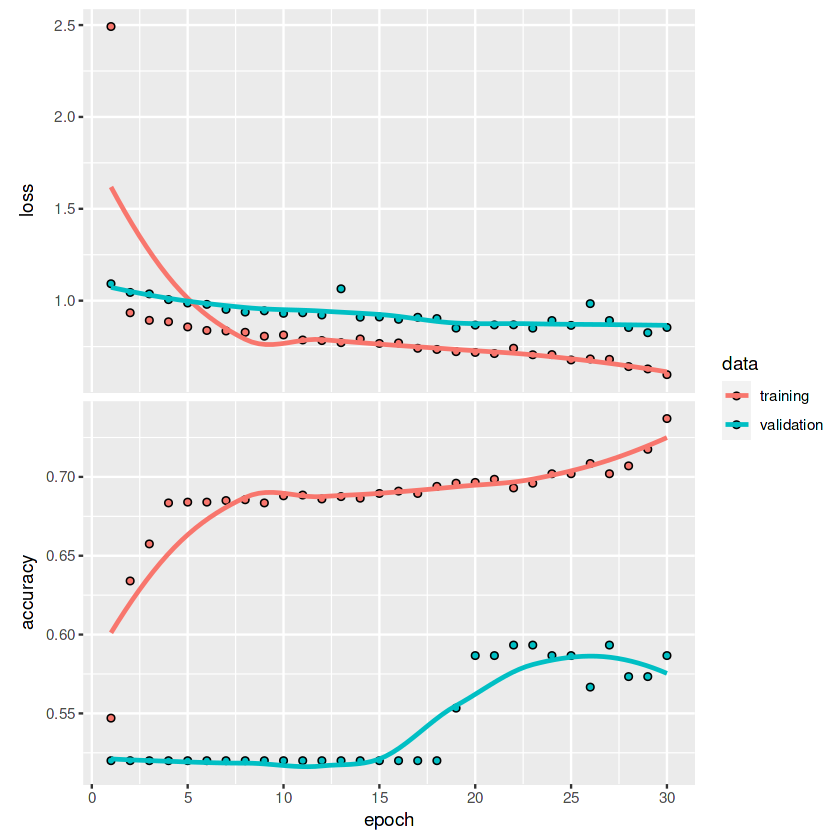

In [9]:
batch_size = 128
nb_classes = 3
img_rows = image_size
img_cols = image_size
kernel_size = c(3, 3)
input_shape = c(img_rows, img_cols, 3)
pool_size = c(2, 2)

## Define model 
scratch_model <- keras_model_sequential() %>% 
  # convolutional part of the CNN
  layer_conv_2d(filters = 16, kernel_size = kernel_size, padding = "same",
                activation = "relu",input_shape = input_shape) %>% 
  layer_conv_2d(filters = 16, kernel_size = kernel_size, padding = "same",
                activation = "relu") %>% 
  layer_max_pooling_2d(pool_size = pool_size) %>%
  
  layer_conv_2d(filters = 32, kernel_size = kernel_size, padding = "same",
                activation = "relu") %>% 
  layer_conv_2d(filters = 32, kernel_size = kernel_size, padding = "same",
                activation = "relu") %>% 
  layer_max_pooling_2d(pool_size = pool_size) %>%
  
  layer_conv_2d(filters = 64, kernel_size = kernel_size, padding = "same",
                activation = "relu") %>% 
  layer_conv_2d(filters = 46, kernel_size = kernel_size, padding = "same",
                activation = "relu") %>% 
  layer_max_pooling_2d(pool_size = pool_size) %>%
  
  
  layer_flatten() %>% 
  
  #fully connected part of the CNN
  layer_dense(units = 100, activation = "relu") %>% 
  layer_dropout(rate = 0.5) %>%
  layer_dense(units = 100, activation = "relu") %>% 
  layer_dropout(rate = 0.5) %>%
  layer_dense(units = nb_classes, activation = "softmax")

summary(scratch_model)

# compile model and intitialize weights
scratch_model %>% compile(
  optimizer = "adam",
  loss = "categorical_crossentropy",
  metrics = c("accuracy")
)

# train the model (can take 2-3 minuntes)
scratch_history <- scratch_model %>% fit(
  X_train, Y_train, 
  epochs = 30, batch_size=batch_size,
  verbose=0, validation_data = list(X_val, Y_val))
plot(scratch_history)
  
## Show model accuracy
scratch_accuracy <- scratch_model %>% evaluate(X_test, Y_test, verbose=0)

In [10]:
scratch_accuracy

loss  accuracy 
0.8034379 0.6833333

# 4) Identify miss-labeled images


In [13]:
predictions <- scratch_model %>%
  predict(X_test)  %>% 
  k_argmax() + 1 # Index shift python vs r

predictions <- as.array(predictions)
  
### Sanity check: Accuracy
(mean(as.integer(y_test) == predictions))

[1] 0.6833333

In [14]:
miss_classified <- as.integer(y_test) != predictions

## Get wrongly assigned images
X_test_miss <- X_test[miss_classified,,,]
y_test_miss <- y_test[miss_classified]

In [15]:
## Miss-classified fraction per class
table(y_test_miss) /table(y_test)

y_test_miss
            melanoma                nevus seborrheic_keratosis 
          0.94017094           0.07124682           0.57777778 

In [17]:
table(y_test_miss)

y_test_miss
            melanoma                nevus seborrheic_keratosis 
                 110                   28                   52 

In [20]:
table(y_test)

y_test
            melanoma                nevus seborrheic_keratosis 
                 117                  393                   90 

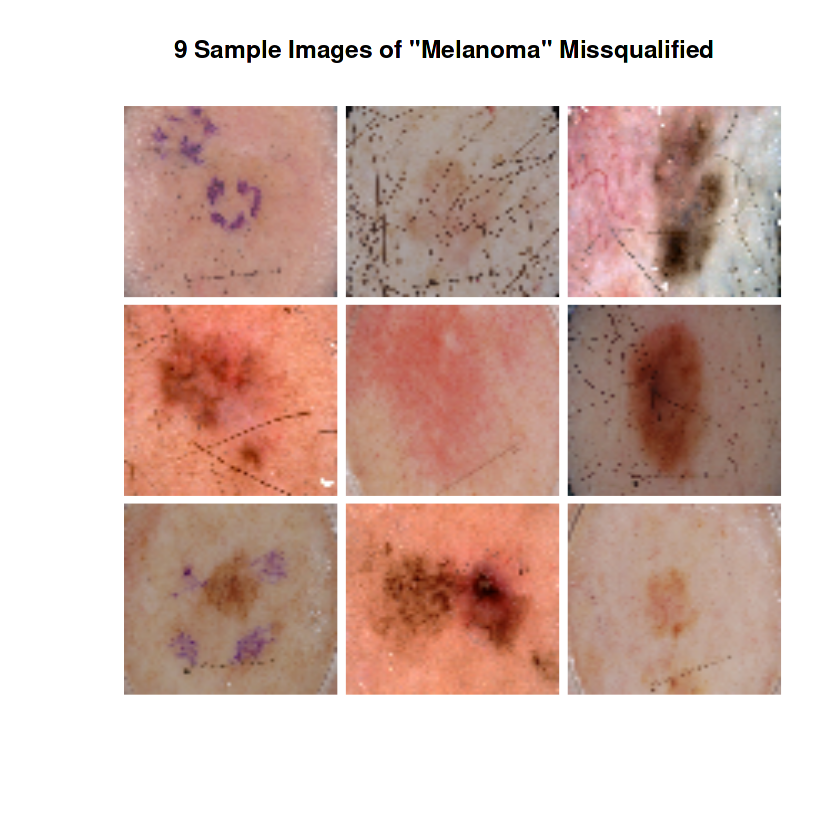

In [150]:
melanoma_miss = sample(which(y_test_miss == "melanoma"), 9)

# initialize plot
op <- par(bg = "thistle")
plot(c(100, 250), c(100, 250), type = "n", axes = FALSE, xlab = "", ylab = "", main = "9 Sample Images of \"Melanoma\" Missqualified")

col = 100
imageId = 1

# loop thorugh sample images
for (i in 1:3) {   
    row = 100
    for (j in 1:3) {
       rasterImage(X_test_miss[melanoma_miss[imageId],,,]/255,
              row, col, row + 50, col + 50)
       imageId = imageId + 1
       row = row + 52
    }   
    col = col + 52
}

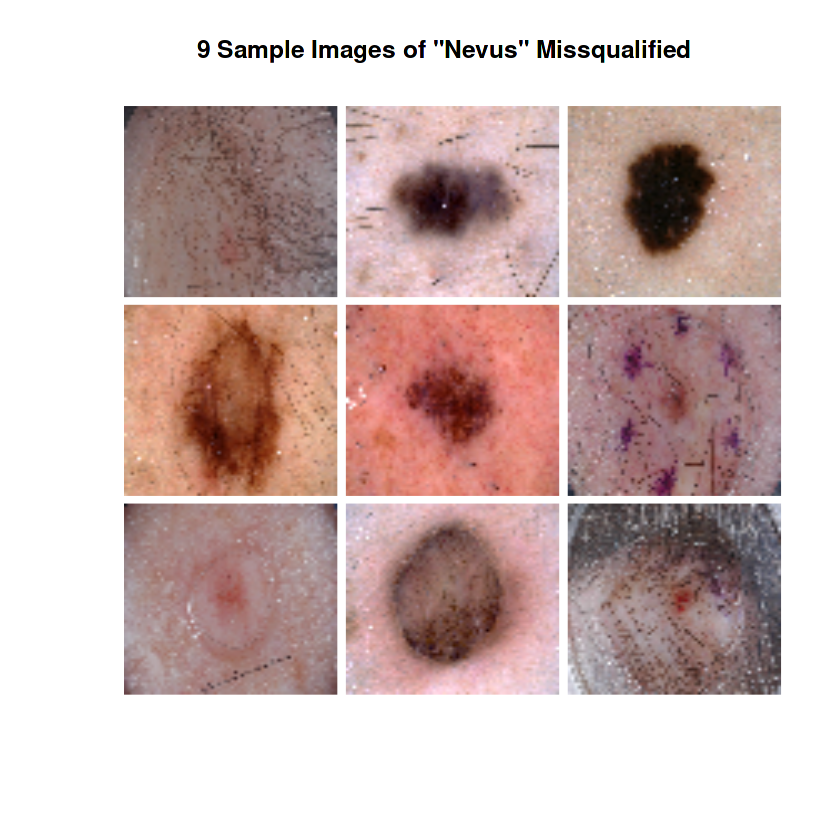

In [151]:
nevus_miss = sample(which(y_test_miss == "nevus"), 9)

# initialize plot
op <- par(bg = "thistle")
plot(c(100, 250), c(100, 250), type = "n", axes = FALSE, xlab = "", ylab = "", main = "9 Sample Images of \"Nevus\" Missqualified")

col = 100
imageId = 1

# loop thorugh sample images
for (i in 1:3) {   
    row = 100
    for (j in 1:3) {
       rasterImage(X_test_miss[nevus_miss[imageId],,,]/255,
              row, col, row + 50, col + 50)
       imageId = imageId + 1
       row = row + 52
    }   
    col = col + 52
}

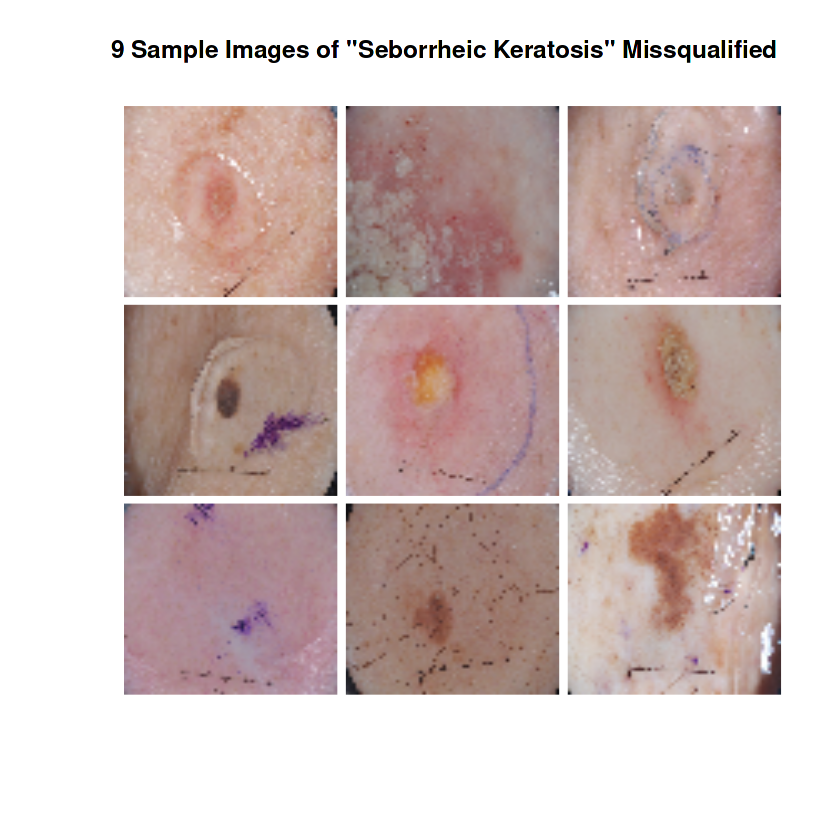

In [153]:
seborrheic_keratosis_miss = sample(which(y_test_miss == "seborrheic_keratosis"), 9)

# initialize plot
op <- par(bg = "thistle")
plot(c(100, 250), c(100, 250), type = "n", axes = FALSE, xlab = "", ylab = "", main = "9 Sample Images of \"Seborrheic Keratosis\" Missqualified")

col = 100
imageId = 1

# loop thorugh sample images
for (i in 1:3) {   
    row = 100
    for (j in 1:3) {
       rasterImage(X_test_miss[seborrheic_keratosis_miss[imageId],,,]/255,
              row, col, row + 50, col + 50)
       imageId = imageId + 1
       row = row + 52
    }   
    col = col + 52
}